# Fingerprints task
Znovu začneme tím, že nainportujeme baličky a načtemé naší oblíbené datasety. Ligandy z datasetu Cytochromu jsou v promenné <b>cyto_ligands</b>, a ligandy Drugbanku leží v <b>drugs</b>

In [2]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import seaborn as sns
import csv

with open('CHEMBL26-chembl_26_activity.csv', 'r') as csvfile:
    inp = csv.DictReader(csvfile, delimiter=";")
    cyto_ligands = [Chem.MolFromSmiles(el['Smiles']) for el in inp if not el['Smiles'] == None]

suppl = Chem.SDMolSupplier('drugbank.sdf')
drugs = [m for m in suppl if not m == None]

RDKit ERROR: [23:52:14] Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [23:52:14] ERROR: Could not sanitize molecule ending on line 20009
RDKit WARNING: [23:52:14] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit WARNING: [23:52:14] Warning: conflicting stereochemistry at atom 5 ignored.
RDKit ERROR: [23:52:14] ERROR: Explicit valence for atom # 7 N, 4, is greater than permitted
RDKit ERROR: [23:52:15] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [23:52:15] ERROR: Could not sanitize molecule ending on line 250947
RDKit ERROR: [23:52:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [23:52:15] Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [23:52:15] ERROR: Could not sanitize molecule ending on line 258130
RDKit ERROR: [23:52:15] ERROR: Explicit valence for atom # 17 O, 3, is greater than permitted
RDKit ERROR: [23:52:15] Can't kek

RDKit ERROR: [23:52:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 9
RDKit ERROR: 
RDKit ERROR: [23:52:15] Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [23:52:15] ERROR: Could not sanitize molecule ending on line 466177
RDKit ERROR: [23:52:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 16 17 18 19 20
RDKit ERROR: 
RDKit ERROR: [23:52:15] Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [23:52:15] ERROR: Could not sanitize molecule ending on line 468852
RDKit ERROR: [23:52:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 7 8 9 10 17
RDKit ERROR: 
RDKit ERROR: [23:52:15] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:52:15] ERROR: Could not sanitize molecule ending on line 469201
RDKit ERROR: [23:52:15] ERROR: Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
RDKit ERROR: 
RDKit ERROR: [23:52:15] Explicit valence for atom # 53 N, 4, is greater than pe

RDKit ERROR: [23:52:16] ERROR: Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5 6 7 8 9 10
RDKit ERROR: 
RDKit ERROR: [23:52:16] Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [23:52:16] ERROR: Could not sanitize molecule ending on line 995692
RDKit ERROR: [23:52:16] ERROR: Explicit valence for atom # 0 Be, 3, is greater than permitted
RDKit ERROR: [23:52:17] Explicit valence for atom # 0 C greater than permitted
RDKit ERROR: [23:52:17] ERROR: Could not sanitize molecule ending on line 1151592


Ted' opakujeme zakladni operaci z cvika:

- hledaní fingerprintů pro ligandy Cytochromu a Drugbanku
- počet setkání každeho bitu pro každy dataset
- škalovaní těch počtů
- sčitani rozdilu těch hodnot

In [3]:
cyto_ligands_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in cyto_ligands]
drugs_ecfp = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in drugs]

def ecfpSum(mol_list):
    sums = [0]*mol_list[0].GetNumBits()
    for key in mol_list:
        for onbit in key.GetOnBits():
            sums[onbit] += 1
    return sums


cyto_ligands_ecfp_sums = ecfpSum(cyto_ligands_ecfp)
drugs_ecfp_sums = ecfpSum(drugs_ecfp)

cyto_len = len(cyto_ligands_ecfp)
drugs_len = len(drugs_ecfp)
cyto_ligands_ecfp_scaled = [x/cyto_len for x in cyto_ligands_ecfp_sums]
drugs_ecfp_scaled = [x/drugs_len for x in drugs_ecfp_sums]


cyto_drugbank_differences = [(i, a_b[0] - a_b[1]) for i, a_b in enumerate(zip(cyto_ligands_ecfp_scaled, drugs_ecfp_scaled))]
cyto_drugbank_differences.sort(key=lambda x: x[1])

ecfp_diff_count = pd.DataFrame(data = { 'ecfp_#' : [x[0] for x in cyto_drugbank_differences],
                                        'values' : [x[1] for x in cyto_drugbank_differences]
                                        })

Zkusime opakovát viyualizaci rozdilu jednotlivých bitu. V minulem ukolu měli jsme přiblizně 160 kličů, a bylo ještě to rozlišitelně, ale tady mame 1024 kličů, tak myslim, že bude to nějaky nerozlišitelný harmonogram.

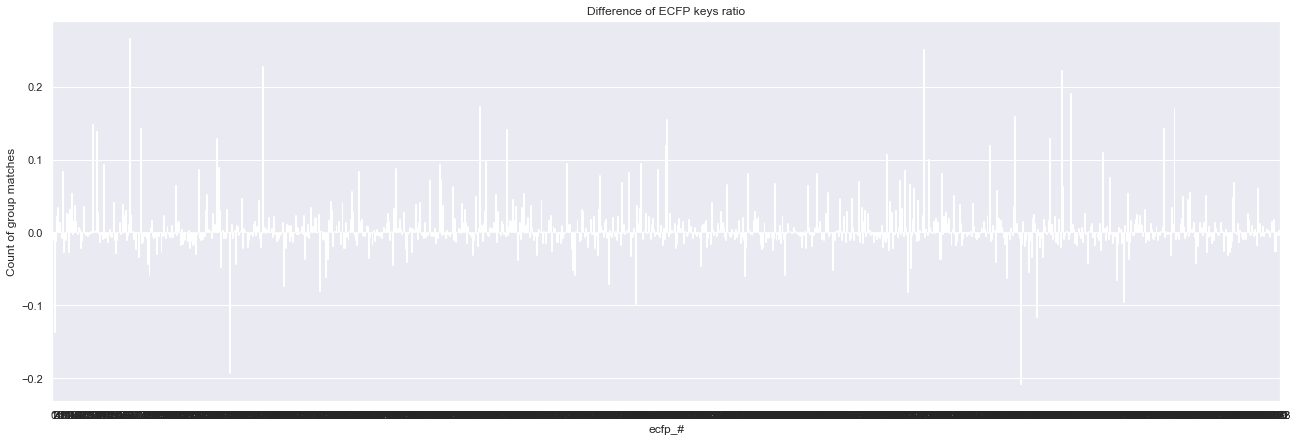

In [4]:
sns.set(rc={'figure.figsize':(22, 7)})
with sns.axes_style("darkgrid"):
    p = sns.barplot(x='ecfp_#', y='values', data=ecfp_diff_count)
    p.set_title(f"Difference of ECFP keys ratio")
    p.set_ylabel("Count of group matches")     

Je to tak. Mamé nerozlišitelný harmonogram. Ale vidime, že dataset Cytochromu ma 4 nejhojnějších bitu (vice než 0.2), když dataset Drugbanku ma přiblizně 3 nejhojnější bitu (meně než -0.1). Tak, poprvé nakreslime distribuci rozdilu, a pak přejdeme k analyze nejhojnějších bitu (spoiler: 807 a 64).

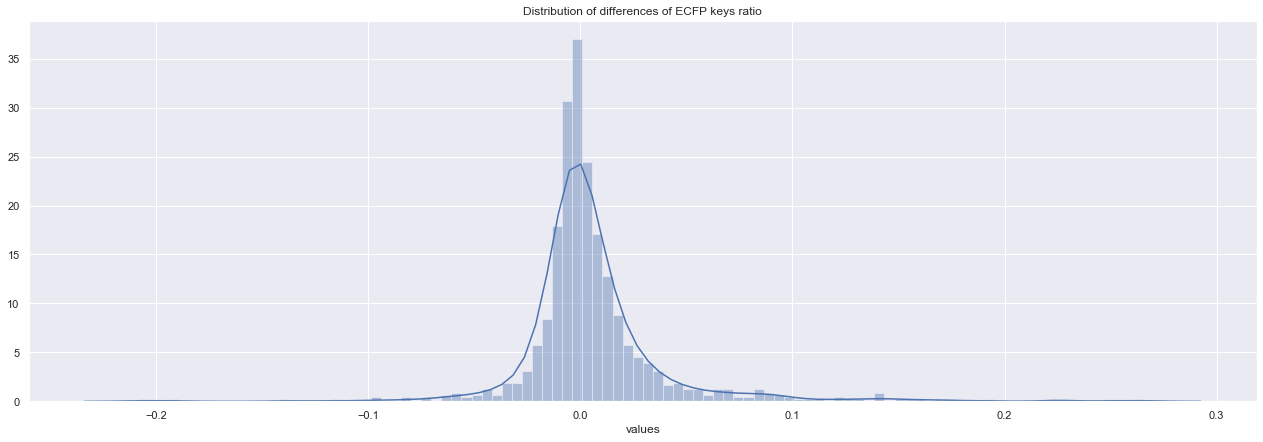

In [5]:
sns.set(rc={'figure.figsize':(22, 7)})
with sns.axes_style("darkgrid"):
    p = sns.distplot(ecfp_diff_count['values'], bins=100)
    p.set_title(f"Distribution of differences of ECFP keys ratio")

In [6]:
cyto_drugbank_differences[:4], cyto_drugbank_differences[-4:]

([(807, -0.20797294654847442),
  (147, -0.19248785074987682),
  (1, -0.13722069908659917),
  (820, -0.11652042962897795)],
 [(841, 0.2233942172760667),
  (175, 0.2281528198914407),
  (726, 0.2517430220283977),
  (64, 0.26682902631157746)])

In [13]:
def substructures_of_bit_ecfp4_1024(mol, bit):
    submols = []
    bitinfo = {}
    Chem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, bitInfo=bitinfo)
    for bit, atom_radius in bitinfo.items():
        atom, radius = atom_radius[0]
        if radius == 0: # radius 0 means just the atom, not useful as path
            continue
        it_atoms = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom)
        submols.append(Chem.PathToSubmol(mol, it_atoms))
    return submols

In [14]:
substructure_smiles = {}
for ligand in cyto_ligands:
    for submol in substructures_of_bit_ecfp4_1024(ligand, 64):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles[subsmiles] = substructure_smiles.get(subsmiles, 0) + 1

substructure_smiles

{'CC=CC(C)=[N+]': 8,
 'cc(c)N': 2876,
 'C[N+]': 62,
 'ccc(c(c)C)c(c)c': 112,
 'CN': 2392,
 'cc(c)S(=O)(=O)[O-]': 30,
 'C=CC(C=C)=C(c)c': 18,
 'cc(S)cc(c)c': 24,
 'cc(c)O': 6678,
 'C=C(C)C': 1382,
 'cc(c)C(=C(C)C)c(c)c': 20,
 '[O-]S': 28,
 'cc(c)S': 752,
 'cc(c)c': 2910,
 'cc(c)N(C)C': 178,
 'CC(C)=[N+](C)C': 8,
 'cc(c)C': 14384,
 'C=C(c)c': 80,
 'ccc(cc)c(c)c': 356,
 'CC(C)=[N+]': 10,
 'O=S': 878,
 'cc(c)S(=O)(=O)O': 24,
 'cc(C)c(O)c(c)S': 2,
 'ccc(cc)S(=O)(=O)O': 30,
 'C=CC': 2856,
 'cO': 1348,
 'OS': 106,
 'C=[N+](C)C': 10,
 'cS(=O)(=O)O': 44,
 'ccc(c(c)O)S(=O)(=O)[O-]': 2,
 'cccc(c)C': 10468,
 'CN(C)c': 450,
 'cccc(c)c': 1948,
 'ccc': 25996,
 'ccc(cc)N(C)C': 600,
 'C=CC(C=C)=[N+](C)C': 8,
 'cS(=O)(=O)[O-]': 24,
 'C=C(c)c(cc)cc': 46,
 'cccc(c)N': 2314,
 'C=C(c)c(c(c)O)c(c)c': 2,
 'C=C(C)C=CC': 34,
 'CCC(=O)O': 126,
 'CC(C)(c)c': 38,
 'CCC': 13476,
 'cccc(c)O': 4374,
 'CCCC(=O)O': 172,
 'CO': 7440,
 'CC': 6804,
 'CCCC(C)(c)c': 24,
 'ccc(cc)C(C)(C)c': 30,
 'cc(c)C(C)(CC)c(c)c': 4,
 'CC

In [15]:
substructure_smiles_db = {}
for drug in drugs:
    for submol in substructures_of_bit_ecfp4_1024(drug, 807):
        subsmiles = Chem.MolToSmiles(submol)
        substructure_smiles_db[subsmiles] = substructure_smiles_db.get(subsmiles, 0) + 1
substructure_smiles_db

{'CCC': 7253,
 'CC(N)=O': 2235,
 'cccc(c)C': 3546,
 'ccc': 8932,
 'CCc': 853,
 'CCNC(C)=O': 230,
 'CNC(=O)[C@H](C)N': 363,
 'CC(C)N': 2642,
 'CNC': 2123,
 'CN': 2136,
 'ccccc': 3387,
 'CCCN(C)C': 692,
 'CN(C)C': 1545,
 'CC[C@H](NC)C(N)=O': 122,
 'cC[C@@H](N)C(N)=O': 13,
 'CC': 3776,
 'cccc(c)O': 1313,
 'CCC[C@@H](C)N': 366,
 'CCC(N)=O': 89,
 'CO': 5415,
 'CNC(=O)CN': 33,
 'C[C@H](N)C(=O)N(C)C': 140,
 'CCN': 3161,
 'N=C(N)N': 147,
 'CCCCN': 612,
 'CC(C)C[C@@H](C)N': 102,
 'CCN(C(C)=O)C(C)C': 166,
 'CC(=O)NC(C)C': 685,
 'cO': 804,
 'cC[C@H](NC)C(N)=O': 64,
 'C[C@H](N)C(=O)O': 354,
 'CC[C@@H](C(N)=O)N(C)C': 100,
 'CNCC(N)=O': 49,
 'CCC(C)C': 211,
 'CC(=O)O': 2064,
 'cc(c)C': 5362,
 'cc(c)O': 2207,
 'ccc(O)cc': 341,
 'CC(C)C': 2109,
 'CC[C@H](C)[C@@H](C)N': 25,
 'C[C@@H](N)C(=O)N(C)C': 51,
 'CCCNC': 339,
 'ccc(cc)CC': 674,
 'CN[C@H](C(N)=O)C(C)C': 49,
 'C=O': 4826,
 'CNC(=N)N': 51,
 'C[C@@H](N)CC(N)=O': 30,
 'CCCC(=O)O': 322,
 'CC[C@H](NC)C(=O)O': 65,
 'cc(c)C[C@@H](C)N': 233,
 'CCNC(=N)N'

In [18]:
cyto_max = [0,0]
drug_max = [0,0]

for key, val in substructure_smiles.items():
    if val > cyto_max[1]:
        cyto_max = [key, val]
for key, val in substructure_smiles_db.items():
    if val > drug_max[1]:
        drug_max = [key, val]

print(f'The most abundant substructure, which set on bit 64 is {cyto_max[0]}, which triggered this bit {cyto_max[1]} times')
print(f'The most abundant substructure, which set on bit 807 is {drug_max[0]}, which triggered this bit {drug_max[1]} times')

The most abundant substructure, which set on bit 64 is ccc, which triggered this bit 25996 times
The most abundant substructure, which set on bit 807 is ccc, which triggered this bit 8932 times


Vidime, že oba datasetu mají stejnou substrukturu, ktera zapnula jejich nejhonějši bity fingerprintů